# Import

In [1]:
import numpy as np
import pandas as pd
import json
import champ_dataset
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import tensorflow_datasets as tfds
import tensorflow as tf
from datasets import load_dataset
from tensorflow.python.client import device_lib
import re
import os
from sklearn.utils import shuffle


os.environ["TOKENIZERS_PARALLELISM"] = "false"

2024-12-07 23:29:19.289351: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 23:29:19.306120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 23:29:19.325238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 23:29:19.331053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 23:29:19.345760: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.17.0


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2024-12-07 23:29:39.523614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 22261 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-12-07 23:29:39.525498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:1 with 22261 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-12-07 23:29:39.527155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:2 with 22261 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-12-07 23:29:39.528598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:3 with 22261 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-12-07 23:29:39.529861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3577045181806099102
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23342743552
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 5
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 6
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 7
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5252215808611826481
 physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capabil

In [4]:
MODEL_NAME = 'train_concept'
RUN = 'run10'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/Data/MATH/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN + '/'
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Duong_LLM/Data/MATH/
/nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run10/


In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data hendrycks

In [6]:
# Algebra: 16 topics
# Polynomials, Sequences, and Calculus: 13 topics
# Number Theory: 13 topics
# Geometry: 1 topic
# Measurement: 6 topics
# Probability and Combinatorics: 4 topics
# Comparison and Reasoning: 9 topics
TOPIC = ['algebra,polynomial_sequences_calculus,number_theory,geometry,measurement,probability_combinatorics,comparison_reasoning']

In [7]:
data_dict = {
    'number_theory': [],
    'intermediate_algebra': [],
    'algebra': [],
    'geometry': [],
    'precalculus': [],
    'counting_and_probability': [],
    'prealgebra': []
}


for root, dirs, files in os.walk(DATA_DIR):
    for filename in files:
        if filename.endswith('.json'):
            file_path = os.path.join(root, filename)
            subfolder_name = os.path.basename(root)
            if subfolder_name in data_dict:
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    
                    data_dict[subfolder_name].append(data['problem'])

In [8]:
data

{'problem': 'What is the average of all positive integers that have four digits when written in base $3$, but two digits when written in base $6$? Write your answer in base $10$.',
 'level': 'Level 5',
 'type': 'Number Theory',
 'solution': 'If an integer $n$ has four digits in base $3$, then $3^3\\le n<3^4$. If an integer $n$ has two digits in base $6$, then $6^1\\le n<6^2$. The overlap of these intervals is $$\\{27,28,29,30,31,32,33,34,35\\}.$$The average of the integers in this set is $\\frac{27+35}{2} = \\boxed{31}$.'}

In [9]:


rename_mapping = {
    'intermediate_algebra': 'algebra',
    'precalculus': 'polynomial_sequences_calculus',
    'counting_and_probability': 'probability_combinatorics',
    'prealgebra': 'algebra'
}


def remove_formatting(text):
    # Remove LaTeX commands
    text = re.sub(r'\\[a-zA-Z]+', '', text)
    # Remove curly braces
    text = re.sub(r'{|}', '', text)
    # Remove Markdown formatting (e.g., **bold**, *italic*, `code`)
    text = re.sub(r'\*\*|\*|`', '', text)
    # Remove Markdown headers (e.g., # Header)
    text = re.sub(r'#', '', text)
    # Remove escape characters
    text = re.sub(r'\\', '', text)
    # remove special character
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\$', '', text)
    # Remove everything after '(A)'
    text = re.sub(r'\(A\).*', '', text)
    text = re.sub(r'\(a\).*', '', text)
    # Remove everything after "b'"
    text = re.sub(r'b\'', '', text)
    return text



In [10]:
df_all = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))
df_all = df_all.melt(var_name='topic',value_name='problem')
df_all = df_all.dropna().reset_index(drop=True)
df_all['problem'] = df_all['problem'].apply(remove_formatting)
df_all['topic'] = df_all['topic'].replace(rename_mapping)
df_all

,topic,problem
0,number_theory,What is the smallest prime divisor of 5^23 + 7...
1,number_theory,What is the largest positive integer with only...
2,number_theory,What is the greatest prime factor of 12! + 14!...
3,number_theory,What is the largest four-digit negative intege...
4,number_theory,How many positive divisors of 150 are not divi...
...,...,...
12501,algebra,Four students agreed to pool their savings to ...
12502,algebra,What is the perimeter of trapezoid ABCD? [asy]...
12503,algebra,Three identical squares are placed side by sid...
12504,algebra,If the square root of the length of the hypote...


In [11]:
df_all.groupby('topic').size()

topic
algebra                          7205
geometry                         1355
number_theory                    1409
polynomial_sequences_calculus    1292
probability_combinatorics        1245
dtype: int64

In [12]:
df_algebra = df_all[df_all['topic'] == 'algebra'].copy()
df_all = df_all[df_all['topic'] != 'algebra']
df_all.groupby('topic').size()

topic
geometry                         1355
number_theory                    1409
polynomial_sequences_calculus    1292
probability_combinatorics        1245
dtype: int64

# Load data deepmind

In [13]:
topic = ['algebra__linear_1d', 'algebra__linear_1d_composed', 'algebra__linear_2d', 'algebra__linear_2d_composed', \
         'algebra__polynomial_roots', 'algebra__polynomial_roots_composed', \
         'algebra__sequence_next_term', 'algebra__sequence_nth_term', \
         'arithmetic__add_or_sub', 'arithmetic__add_or_sub_in_base', 'arithmetic__add_sub_multiple', 'arithmetic__div', \
         'arithmetic__mixed', 'arithmetic__mul', 'arithmetic__mul_div_multiple', 'arithmetic__nearest_integer_root', 'arithmetic__simplify_surd', \
         'calculus__differentiate', 'calculus__differentiate_composed', \
         'comparison__closest', 'comparison__closest_composed', 'comparison__kth_biggest', 'comparison__kth_biggest_composed', \
         'comparison__pair', 'comparison__pair_composed', 'comparison__sort', 'comparison__sort_composed', \
         'measurement__conversion', 'measurement__time', \
         'numbers__base_conversion', 'numbers__div_remainder', 'numbers__div_remainder_composed', 'numbers__gcd', 'numbers__gcd_composed',\
         'numbers__is_factor', 'numbers__is_factor_composed', 'numbers__is_prime', 'numbers__is_prime_composed', 'numbers__lcm', \
         'numbers__lcm_composed', 'numbers__list_prime_factors', 'numbers__list_prime_factors_composed', 'numbers__place_value', \
         'numbers__place_value_composed', 'numbers__round_number', 'numbers__round_number_composed',\
         'polynomials__add', 'polynomials__coefficient_named', 'polynomials__collect', 'polynomials__compose', 'polynomials__evaluate',\
         'polynomials__evaluate_composed', 'polynomials__expand', 'polynomials__simplify_power', 'probability__swr_p_level_set',\
         'probability__swr_p_sequence']

In [14]:
from datasets import load_dataset
train = load_dataset("deepmind/math_dataset", 'algebra__linear_1d_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_data = pd.DataFrame()
begin = 10000
end = begin + 300 # only take limit problem
df_data['problem'] = train['question'][begin:end]
df_data['topic'] = 'algebra'

In [15]:
train = load_dataset("deepmind/math_dataset", 'algebra__linear_2d_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 300 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'algebra'

#concat
df_data = pd.concat([df_data,df_temp])

In [16]:
train = load_dataset("deepmind/math_dataset", 'algebra__polynomial_roots_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'algebra'

#concat
df_data = pd.concat([df_data,df_temp])

In [17]:
train = load_dataset("deepmind/math_dataset", 'arithmetic__add_sub_multiple',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'algebra'

#concat
df_data = pd.concat([df_data,df_temp])

In [18]:
train = load_dataset("deepmind/math_dataset", 'arithmetic__add_or_sub_in_base',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'algebra'

#concat
df_data = pd.concat([df_data,df_temp])

In [19]:
train = load_dataset("deepmind/math_dataset", 'arithmetic__mul_div_multiple',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 300 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'algebra'

#concat
df_data = pd.concat([df_data,df_temp])

In [20]:
train = load_dataset("deepmind/math_dataset", 'algebra__sequence_next_term',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'algebra'

#concat
df_data = pd.concat([df_data,df_temp])

In [21]:
train = load_dataset("deepmind/math_dataset", 'arithmetic__mixed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 400 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'algebra'

#concat
df_data = pd.concat([df_data,df_temp])

In [22]:
train = load_dataset("deepmind/math_dataset", 'arithmetic__simplify_surd',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 400 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'algebra'

#concat
df_data = pd.concat([df_data,df_temp])

In [23]:
df_data

,problem,topic
0,b'Suppose 8*j - 154 = 910. Let l = 139 - j. So...,algebra
1,b'Let y(p) = -6*p**2 + 2*p + 10. Let h be y(4)...,algebra
2,b'Let g(w) = -w**3 + 5*w**2 - 6*w + 2. Let p b...,algebra
3,b'Suppose 27*p + 71 - 44 = 0. Let f(l) = -12*l...,algebra
4,b'Let p be (-62)/6 - 1/(-3). Let q be (-6)/(-2...,algebra
...,...,...
395,b'Simplify (sqrt(33)*-2*-3 + 2*sqrt(4752))/(-2...,algebra
396,b'Simplify ((sqrt(11) - (sqrt(539) + 1*sqrt(53...,algebra
397,b'Simplify 2*(1*(sqrt(1800) + 2)**2 + 2 + (sqr...,algebra
398,b'Simplify ((sqrt(190) - 1*sqrt(190))/sqrt(10)...,algebra


In [24]:
train = load_dataset("deepmind/math_dataset", 'polynomials__compose',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 300 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'polynomial_sequences_calculus'

#concat
df_data = pd.concat([df_data,df_temp])

In [25]:
train = load_dataset("deepmind/math_dataset", 'polynomials__evaluate_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 500 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'polynomial_sequences_calculus'

#concat
df_data = pd.concat([df_data,df_temp])

In [26]:
train = load_dataset("deepmind/math_dataset", 'calculus__differentiate_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 500 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'polynomial_sequences_calculus'

#concat
df_data = pd.concat([df_data,df_temp])

In [27]:
df_data

,problem,topic
0,b'Suppose 8*j - 154 = 910. Let l = 139 - j. So...,algebra
1,b'Let y(p) = -6*p**2 + 2*p + 10. Let h be y(4)...,algebra
2,b'Let g(w) = -w**3 + 5*w**2 - 6*w + 2. Let p b...,algebra
3,b'Suppose 27*p + 71 - 44 = 0. Let f(l) = -12*l...,algebra
4,b'Let p be (-62)/6 - 1/(-3). Let q be (-6)/(-2...,algebra
...,...,...
495,b'Let b(d) be the first derivative of 9*d**7/7...,polynomial_sequences_calculus
496,b'Let r(s) = -s + 3*s**2 + s**2 - 4*s**2 - s**...,polynomial_sequences_calculus
497,b'Let t(p) be the third derivative of p**6/24 ...,polynomial_sequences_calculus
498,b'What is the first derivative of -61*p**3 + 1...,polynomial_sequences_calculus


In [28]:
train = load_dataset("deepmind/math_dataset", 'numbers__div_remainder_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])


In [29]:
train = load_dataset("deepmind/math_dataset", 'numbers__gcd_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [30]:
train = load_dataset("deepmind/math_dataset", 'numbers__is_factor_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [31]:
train = load_dataset("deepmind/math_dataset", 'numbers__is_prime_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [32]:
train = load_dataset("deepmind/math_dataset", 'numbers__lcm_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [33]:
train = load_dataset("deepmind/math_dataset", 'numbers__list_prime_factors_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [34]:
train = load_dataset("deepmind/math_dataset", 'numbers__place_value_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [35]:
train = load_dataset("deepmind/math_dataset", 'numbers__round_number_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [36]:
df_data

,problem,topic
0,b'Suppose 8*j - 154 = 910. Let l = 139 - j. So...,algebra
1,b'Let y(p) = -6*p**2 + 2*p + 10. Let h be y(4)...,algebra
2,b'Let g(w) = -w**3 + 5*w**2 - 6*w + 2. Let p b...,algebra
3,b'Suppose 27*p + 71 - 44 = 0. Let f(l) = -12*l...,algebra
4,b'Let p be (-62)/6 - 1/(-3). Let q be (-6)/(-2...,algebra
...,...,...
95,b'Let b = 1212 - 1211.91173. Round b to 3 deci...,number_theory
96,b'Let u = -3.381 - -185.481. Round u to the ne...,number_theory
97,b'Let l = -2.9889629 - 1329.5983371. Let s = 1...,number_theory
98,b'Let t = 21324.9989507 + -21325. What is t ro...,number_theory


In [37]:
train = load_dataset("deepmind/math_dataset", 'measurement__conversion',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'measurement'

#concat
df_data = pd.concat([df_data,df_temp])

In [38]:
train = load_dataset("deepmind/math_dataset", 'measurement__time',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'measurement'

#concat
df_data = pd.concat([df_data,df_temp])

In [39]:
df_data

,problem,topic
0,b'Suppose 8*j - 154 = 910. Let l = 139 - j. So...,algebra
1,b'Let y(p) = -6*p**2 + 2*p + 10. Let h be y(4)...,algebra
2,b'Let g(w) = -w**3 + 5*w**2 - 6*w + 2. Let p b...,algebra
3,b'Suppose 27*p + 71 - 44 = 0. Let f(l) = -12*l...,algebra
4,b'Let p be (-62)/6 - 1/(-3). Let q be (-6)/(-2...,algebra
...,...,...
595,b'What is 303 minutes after 1:29 AM?\n',measurement
596,b'What is 470 minutes before 4:34 AM?\n',measurement
597,b'How many minutes are there between 3:14 AM a...,measurement
598,b'What is 467 minutes after 5:48 PM?\n',measurement


In [40]:
train = load_dataset("deepmind/math_dataset", 'probability__swr_p_level_set',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'probability_combinatorics'

#concat
df_data = pd.concat([df_data,df_temp])

In [41]:
train = load_dataset("deepmind/math_dataset", 'probability__swr_p_sequence',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'probability_combinatorics'

#concat
df_data = pd.concat([df_data,df_temp])

In [42]:
df_data

,problem,topic
0,b'Suppose 8*j - 154 = 910. Let l = 139 - j. So...,algebra
1,b'Let y(p) = -6*p**2 + 2*p + 10. Let h be y(4)...,algebra
2,b'Let g(w) = -w**3 + 5*w**2 - 6*w + 2. Let p b...,algebra
3,b'Suppose 27*p + 71 - 44 = 0. Let f(l) = -12*l...,algebra
4,b'Let p be (-62)/6 - 1/(-3). Let q be (-6)/(-2...,algebra
...,...,...
595,b'Two letters picked without replacement from ...,probability_combinatorics
596,b'What is prob of sequence ccgc when four lett...,probability_combinatorics
597,b'What is prob of sequence geg when three lett...,probability_combinatorics
598,b'Three letters picked without replacement fro...,probability_combinatorics


In [43]:
train = load_dataset("deepmind/math_dataset", 'comparison__closest_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'comparison_reasoning'

#concat
df_data = pd.concat([df_data,df_temp])

In [44]:
train = load_dataset("deepmind/math_dataset", 'comparison__kth_biggest_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'comparison_reasoning'

#concat
df_data = pd.concat([df_data,df_temp])

In [45]:
train = load_dataset("deepmind/math_dataset", 'comparison__pair_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'comparison_reasoning'

#concat
df_data = pd.concat([df_data,df_temp])

In [46]:
train = load_dataset("deepmind/math_dataset", 'comparison__sort_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'comparison_reasoning'

#concat
df_data = pd.concat([df_data,df_temp])

In [47]:
df_filtered = df_algebra[df_algebra['problem'].str.contains('largest|smallest|minimun|maximun|>|<', case=False, regex=True)]
df_temp = pd.DataFrame()
df_temp['problem'] = df_filtered['problem'].to_list()
df_temp['topic'] = 'comparison_reasoning'

#concat
df_data = pd.concat([df_data,df_temp])

In [48]:
df_data

,problem,topic
0,b'Suppose 8*j - 154 = 910. Let l = 139 - j. So...,algebra
1,b'Let y(p) = -6*p**2 + 2*p + 10. Let h be y(4)...,algebra
2,b'Let g(w) = -w**3 + 5*w**2 - 6*w + 2. Let p b...,algebra
3,b'Suppose 27*p + 71 - 44 = 0. Let f(l) = -12*l...,algebra
4,b'Let p be (-62)/6 - 1/(-3). Let q be (-6)/(-2...,algebra
...,...,...
817,What is the smallest number of marbles that co...,comparison_reasoning
818,What is the largest prime factor of 1391?,comparison_reasoning
819,The capacity of a school is 1100 students and ...,comparison_reasoning
820,Juan's Old Stamping GroundsJuan organizes the ...,comparison_reasoning


# Load data. Concept. Duong data

In [49]:
CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/Data/Duong_data/'

In [50]:
concept_list = pd.read_pickle(DATA_DIR + "all_sub_concepts.pkl")
concept_list

['geometry#Inradius',
 'number_theory#Binary Representation',
 'number_theory#Modular Arithmetic',
 'comparison_reasoning#Resolution Independence',
 'comparison_reasoning#Reflexive Property',
 'algebra#Intersection Points: Determining where the absolute value graph intersects with other functions or lines.',
 'probability_combinatorics#Directed Acyclic Graphs (DAGs)',
 'algebra#Factoring using Distribution',
 'polynomials_sequences_calculus#Polynomial Division: Understanding the process of dividing a polynomial by a binomial.',
 'probability_combinatorics#Probability Distribution Models',
 'algebra#Standard Form of Linear Inequalities',
 "polynomials_sequences_calculus#Rodrigues' formula",
 'number_theory#nth Term Formula',
 'number_theory#Coefficient Alignment',
 'polynomials_sequences_calculus#**Linear Factors**',
 'number_theory#Iterative sequences',
 'geometry#Linear Pair of Angles',
 'number_theory#Base Case (n=0 or n=1)',
 'geometry#Unit Conversion (e.g., cubic meters to cubic ce

In [51]:
kg = pd.read_pickle(DATA_DIR + "kg_math.pkl")
kg

In [52]:
list(kg.successors(concept_list[0]))

['geometry#Incircle',
 'geometry#Application in Non-Right Triangles',
 'geometry#Right Triangle: A triangle with one 90-degree angle, where the height is one of the sides.',
 'geometry#Scalene Triangle: A triangle with all sides of different lengths, requiring careful determination of height for area calculation.',
 'geometry#Tangential Circle Construction',
 'geometry#Area calculation using semi-perimeter',
 'geometry#Application to triangles',
 'geometry#Application in Geometric Calculations',
 'geometry#Solving Non-Right Triangles',
 'geometry#Application in non-right triangles',
 'geometry#Incircle: The circle that is tangent to all three sides of the triangle, with its center at the incenter.',
 'geometry#Semiperimeter: Half of the perimeter of the triangle, used in calculating the radius of the incircle.',
 'geometry#Area calculation of a triangle',
 "geometry#Relation to Brahmagupta's formula",
 'geometry#Application in solving oblique triangles',
 "Jensen's Inequality: A mathem

In [53]:
dataFrame = []
for current_concept in concept_list:
    topic = current_concept.split('#')[0]
    concept_name = remove_formatting(current_concept.split('#')[1])

    #get definition and example
    temp_list = list(kg.successors(current_concept))
    definition = remove_formatting(temp_list[-2])

    #filter example
    example = remove_formatting(temp_list[-1])
    if "Example:" in example:
        example = example.split('Example:')[1]
    if "Sure!" in example:
        example = example.split('Sure!')[1]
    if "Sure," in example:
        example = example.split('Sure,')[1]
    if "Certainly!" in example:
        example = example.split('Certainly!')[1]
    example = example.lstrip()

    #add defition
    definition = concept_name + ": " + definition
    row = [current_concept,topic,definition]
    dataFrame.append(row)

#    #add example
#    example = concept_name + ": " + example
#    row = [current_concept,topic,definition]
#    dataFrame.append(row)
    
df_concept = pd.DataFrame(dataFrame, columns=['search','topic','problem'])
df_concept['topic'] = df_concept['topic'].replace('polynomials_sequences_calculus','polynomial_sequences_calculus')
df_concept

,search,topic,problem
0,geometry#Inradius,geometry,Inradius: Jensen's Inequality: A mathematical ...
1,number_theory#Binary Representation,number_theory,Binary Representation: Orthocenter: The orthoc...
2,number_theory#Modular Arithmetic,number_theory,Modular Arithmetic: Filtration: A sequence of ...
3,comparison_reasoning#Resolution Independence,comparison_reasoning,Resolution Independence: Basis reduction in nu...
4,comparison_reasoning#Reflexive Property,comparison_reasoning,Reflexive Property: Min-Max Scaling: A normali...
...,...,...,...
1174,geometry#Balancing point,geometry,Balancing point: Jensen's Inequality: A mathem...
1175,algebra#Powers of Complex Numbers,algebra,Powers of Complex Numbers: The Birthday Parado...
1176,algebra#Coefficient Sign Changes,algebra,"Coefficient Sign Changes: The complex plane, a..."
1177,comparison_reasoning#Partial Differential Equa...,comparison_reasoning,Partial Differential Equations (PDEs): A recur...


In [54]:
df_concept.groupby('topic').size()

topic
algebra                          227
comparison_reasoning             205
geometry                         231
number_theory                    196
polynomial_sequences_calculus    110
probability_combinatorics        210
dtype: int64

In [55]:
#split into train and test_set
train_temp  = df_concept[:int(len(df_concept) * 0.9)]
test_temp  = df_concept[int(len(df_concept) * 0.9):]

test_temp.groupby('topic').size()

topic
algebra                          21
comparison_reasoning             23
geometry                         26
number_theory                    23
polynomial_sequences_calculus     6
probability_combinatorics        19
dtype: int64

In [56]:
test_temp.to_csv(DATA_DIR + "testset_duong_data.csv")

In [57]:
df_concept = train_temp.drop('search',axis=1)
df_concept

,topic,problem
0,geometry,Inradius: Jensen's Inequality: A mathematical ...
1,number_theory,Binary Representation: Orthocenter: The orthoc...
2,number_theory,Modular Arithmetic: Filtration: A sequence of ...
3,comparison_reasoning,Resolution Independence: Basis reduction in nu...
4,comparison_reasoning,Reflexive Property: Min-Max Scaling: A normali...
...,...,...
1056,polynomial_sequences_calculus,Polynomial behavior at infinity: Fermat's Litt...
1057,number_theory,Integer Solutions: Aspect Ratio Preservation: ...
1058,algebra,Superposition Principle: The minor of a matrix...
1059,algebra,Jordan Canonical Form: Barycentric Coordinates...


In [58]:
df_concept.groupby('topic').size()

topic
algebra                          206
comparison_reasoning             182
geometry                         205
number_theory                    173
polynomial_sequences_calculus    104
probability_combinatorics        191
dtype: int64

In [59]:
#duplicating
df_concept = pd.concat([df_concept] * 1, ignore_index=True)
print(df_concept.shape)
df_concept.groupby('topic').size()

(1061, 2)


topic
algebra                          206
comparison_reasoning             182
geometry                         205
number_theory                    173
polynomial_sequences_calculus    104
probability_combinatorics        191
dtype: int64

# Add concept from CHAMPDATASET

In [60]:
# =================================Load the dataset==================================
# dataset is a champ_dataset.Dataset instance; 'v0' is the dataset used in the paper
dataset = champ_dataset.load('v0')

# =====================Get a random problem and read its content=====================
# get a random problem; dataset.problems is a dictionary
problem_id = random.choice(list(dataset.problems.keys()))
# shortcut for dataset.problems[problem_id]
problem = dataset[problem_id]
# problem identifier (which is equal to problem_id) and problem statement
print(f'{problem.identifier}: {problem.text}')

P_Polynomial_1: What is the remainder of nx^(n+1)−(n+1)x^n+1 divided by (x−1)^2?


In [61]:
concept_keys = dataset.concepts.keys()
data_temp = []

for key in concept_keys:
    concept = dataset[key]
    row = [concept.category, concept.text]
    data_temp.append(row)


df_temp = pd.DataFrame(data_temp,columns=['topic','problem'])
df_temp = df_temp.sample(frac=1, random_state=98).reset_index(drop=True)
df_temp

,topic,problem
0,Algebra,(x±y)^3=x^3±3x^2*y+3x*y^2±y^3.
1,Inequality,"For n non-negative numbers x_1, ..., x_n, we h..."
2,Trigonometry,tan(a)±tan(b)=sin(a±b)/(cos(a)cos(b)).
3,Algebra,"a+a*r+a*r^2+...+a*r^n=a(1-r^(n+1))/(1-r), a+a*..."
4,Number-Theory,"If p is a prime and p | ab, then p | a or p | ..."
...,...,...
84,Algebra,x^2-y^2=(x+y)(x-y).
85,Polynomial,A polynomial f(x) of degree n is reciprocal if...
86,Inequality,"For real numbers a_(1,1)≤...≤a_(1,n), a_(2,1)≤..."
87,Polynomial,A root with multiplicity k for a polynomial f(...


In [62]:
df_temp.groupby('topic').size()

topic
Algebra           9
Combinatorics     8
Function          1
Inequality       18
Number-Theory    29
Polynomial       18
Sequence          3
Trigonometry      3
dtype: int64

In [63]:
#split into train and test_set
train_temp  = df_temp[:int(len(df_temp) * 0.9)]
test_temp  = df_temp[int(len(df_temp) * 0.9):]

test_temp.groupby('topic').size()

topic
Algebra          2
Inequality       2
Number-Theory    2
Polynomial       3
dtype: int64

In [64]:
test_temp.to_csv(DATA_DIR + "testset_champ_data.csv")

In [65]:
df_temp = train_temp.copy()
df_temp

,topic,problem
0,Algebra,(x±y)^3=x^3±3x^2*y+3x*y^2±y^3.
1,Inequality,"For n non-negative numbers x_1, ..., x_n, we h..."
2,Trigonometry,tan(a)±tan(b)=sin(a±b)/(cos(a)cos(b)).
3,Algebra,"a+a*r+a*r^2+...+a*r^n=a(1-r^(n+1))/(1-r), a+a*..."
4,Number-Theory,"If p is a prime and p | ab, then p | a or p | ..."
...,...,...
75,Polynomial,"Let u=x+y+z, v=xy+yz+xz, w=xyz and s_n=x^n+y^n..."
76,Algebra,a^3±b^3=(a+b)(a^2∓ab+b^2).
77,Polynomial,"Let u=x+y, v=xy and s_n=x^n+y^n. Then, we have..."
78,Number-Theory,"For integer x, x^2 mod 9 can take values of 0,..."


In [66]:
df_temp.groupby('topic').size()

topic
Algebra           7
Combinatorics     8
Function          1
Inequality       16
Number-Theory    27
Polynomial       15
Sequence          3
Trigonometry      3
dtype: int64

In [67]:
topic_map = {
    'Algebra':'algebra',
    'Combinatorics':'probability_combinatorics',
    'Function':'algebra',
    'Inequality':'comparison_reasoning',
    'Number-Theory':'number_theory',
    'Polynomial': 'polynomial_sequences_calculus',
    'Sequence': 'polynomial_sequences_calculus',
    'Trigonometry': 'geometry',
}

df_temp['topic'] = df_temp['topic'].map(topic_map)
df_temp.groupby('topic').size()

topic
algebra                           8
comparison_reasoning             16
geometry                          3
number_theory                    27
polynomial_sequences_calculus    18
probability_combinatorics         8
dtype: int64

In [68]:
#duplicating
df_temp = pd.concat([df_temp] * 5, ignore_index=True)
print(df_temp.shape)
df_temp.groupby('topic').size()

(400, 2)


topic
algebra                           40
comparison_reasoning              80
geometry                          15
number_theory                    135
polynomial_sequences_calculus     90
probability_combinatorics         40
dtype: int64

## Merge

In [69]:
df_concept = pd.concat([df_concept,df_temp], ignore_index=True)
print(df_concept.shape)
df_concept.groupby('topic').size()

(1461, 2)


topic
algebra                          246
comparison_reasoning             262
geometry                         220
number_theory                    308
polynomial_sequences_calculus    194
probability_combinatorics        231
dtype: int64

In [70]:
# #drop half of number theory sample
# temp_df = df_concept[df_concept['topic'] == 'number_theory']
# masked = temp_df.iloc[len(temp_df)//2:].index

# df_concept = df_concept.drop(masked).reset_index(drop=True)
# df_concept.groupby('topic').size()

# Finalizing and spliting data

In [71]:
df_data['problem'] = df_data['problem'].apply(remove_formatting)
df_data

,problem,topic
0,Suppose 8j - 154 = 910. Let l = 139 - j. Solve...,algebra
1,Let y(p) = -6p2 + 2p + 10. Let h be y(4). Let ...,algebra
2,Let g(w) = -w3 + 5w2 - 6w + 2. Let p be g(2). ...,algebra
3,Suppose 27p + 71 - 44 = 0. Let f(l) = -12l2 - ...,algebra
4,Let p be (-62)/6 - 1/(-3). Let q be (-6)/(-21)...,algebra
...,...,...
817,What is the smallest number of marbles that co...,comparison_reasoning
818,What is the largest prime factor of 1391?,comparison_reasoning
819,The capacity of a school is 1100 students and ...,comparison_reasoning
820,Juan's Old Stamping GroundsJuan organizes the ...,comparison_reasoning


In [72]:
df_all = pd.concat([df_all,df_data]).reset_index(drop = True)
df_all

,topic,problem
0,number_theory,What is the smallest prime divisor of 5^23 + 7...
1,number_theory,What is the largest positive integer with only...
2,number_theory,What is the greatest prime factor of 12! + 14!...
3,number_theory,What is the largest four-digit negative intege...
4,number_theory,How many positive divisors of 150 are not divi...
...,...,...
14918,comparison_reasoning,What is the smallest number of marbles that co...
14919,comparison_reasoning,What is the largest prime factor of 1391?
14920,comparison_reasoning,The capacity of a school is 1100 students and ...
14921,comparison_reasoning,Juan's Old Stamping GroundsJuan organizes the ...


In [73]:
df_all.groupby('topic').size()

topic
algebra                          2400
comparison_reasoning             2422
geometry                         1355
measurement                      1200
number_theory                    2509
polynomial_sequences_calculus    2592
probability_combinatorics        2445
dtype: int64

In [74]:
max_rows_per_topic = 2500

In [75]:
df_limited = df_all.groupby('topic', group_keys=False, as_index=False)[['topic', 'problem']].apply(
    lambda x: x.sample(min(len(x), max_rows_per_topic if x.name == 'algebra' else max_rows_per_topic), random_state=96))
df_limited = df_limited.reset_index(drop=True)
df_limited

,topic,problem
0,algebra,"What is next in 2277, 4333, 6389, 8445, 10501,..."
1,algebra,"What is next in 14267, 28536, 42805, 57074, 71..."
2,algebra,Let d be (-6 + (-34)/(-6))(-16 + 1). Suppose -...
3,algebra,Simplify (sqrt(441)-4)/(3-1sqrt(7)) - ((-2 + s...
4,algebra,(24/15)/((-36)/90) - (-1443)/370'
...,...,...
14817,probability_combinatorics,Four letters picked without replacement from y...
14818,probability_combinatorics,Two letters picked without replacement from h:...
14819,probability_combinatorics,What is prob of picking 2 t when two letters p...
14820,probability_combinatorics,Find the constant term in the expansion of (10...


In [76]:
topic_mapping = {
    'algebra': 0,
    'polynomial_sequences_calculus': 1,
    'number_theory': 2,
    'geometry': 3,
    'measurement': 4,
    'probability_combinatorics': 5,
    'comparison_reasoning': 6
}

# Apply the mapping to the 'topic' column
df_limited['topic_encoded'] = df_limited['topic'].replace(topic_mapping)

/tmp/ipykernel_13372/1894251133.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_limited['topic_encoded'] = df_limited['topic'].replace(topic_mapping)


In [77]:
df_limited.groupby('topic').size()

topic
algebra                          2400
comparison_reasoning             2422
geometry                         1355
measurement                      1200
number_theory                    2500
polynomial_sequences_calculus    2500
probability_combinatorics        2445
dtype: int64

In [78]:
df_limited.groupby('topic_encoded').size()

topic_encoded
0    2400
1    2500
2    2500
3    1355
4    1200
5    2445
6    2422
dtype: int64

In [79]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()

X = list(df_limited['problem'])
Y = list(df_limited['topic_encoded'])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [81]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


11857
11857
2965
2965


### add concept here

In [82]:
df_concept['topic_encoded'] = df_concept['topic'].replace(topic_mapping)

/tmp/ipykernel_13372/320274069.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_concept['topic_encoded'] = df_concept['topic'].replace(topic_mapping)


In [83]:
X_concept = list(df_concept['problem'])
Y_concept = list(df_concept['topic_encoded'])

In [84]:
X_train = X_train + X_concept
y_train = y_train + Y_concept

In [85]:
from sklearn.utils import shuffle


# Set the seed for reproducibility
X_train, y_train = shuffle(X_train, y_train, random_state=42)



In [86]:
X_train[:10]

['Let a, b, and c be unit vectors such that a  b = a  c = 0, and the angle between b and c is 4.  Then[a = k (b  c)]for some constant k.  Enter all the possible values of k, separated by commas.',
 '2 distinct vertices of an octagon are chosen at random.  What is the probability that they are adjacent?',
 "Let f be 49/(-98)(-3)/((-78)/(-8)). What is the nearest to 1 in -3, 0.06, f, -1?'",
 'If a and b are vectors such that |a| = 7 and |b| = 11, then find all possible values of a  b.Submit your answer in interval notation.',
 "What is prob of picking 3 f when three letters picked without replacement from afaffff?'",
 'The number of ways to choose a set of (unordered) k items from n items is C(n, k).',
 "Simplify -2sqrt(175)-3 + (sqrt(175) - (0 + sqrt(175)))2 + 5 - (5(sqrt(175) + 1) + -3).'",
 "What is the value of 10 - 2 - (-1365)/(-315)?'",
 'The sum of four consecutive positive even integers is a perfect square. What is the least possible sum?',
 "What is 582 minutes before 10:06 AM?'

In [87]:
y_train[:10]

[1, 5, 6, 1, 5, 5, 0, 0, 2, 4]

In [88]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


13318
13318
2965
2965


In [89]:
#load tokenizer
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

/home/qdang1/.conda/envs/tf2/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [90]:
train_dataset = tf.data.Dataset.from_tensor_slices((
dict(train_encodings),
list(y_train)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
dict(test_encodings),
list(y_test)
))

2024-12-07 23:30:57.859651: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22261 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-12-07 23:30:57.860143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22261 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-12-07 23:30:57.860597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22261 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-12-07 23:30:57.861067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22261 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, comp

# Training

In [91]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=7, cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", dropout = 0.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66958855 (255.43 MB)
Trainable params: 66958855 (255.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
config = model.config
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.2,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.2",
  "vocab_size": 30522
}

In [93]:
PATIENCE = 8
EPOCH = 200
BATCH_SIZE = 32

In [94]:

reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.0001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True)

model.fit(train_dataset.shuffle(1000).batch(BATCH_SIZE),epochs=EPOCH,batch_size=BATCH_SIZE,validation_data=test_dataset.shuffle(1000).batch(BATCH_SIZE),
          callbacks=[reduce_LR_On_Plateau,early_stopping])

Epoch 1/200


I0000 00:00:1733632289.852282   13914 service.cc:146] XLA service 0x2aafec1b1e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733632289.852318   13914 service.cc:154]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1733632289.852324   13914 service.cc:154]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1733632289.852328   13914 service.cc:154]   StreamExecutor device (2): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1733632289.852331   13914 service.cc:154]   StreamExecutor device (3): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1733632289.852334   13914 service.cc:154]   StreamExecutor device (4): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1733632289.852337   13914 service.cc:154]   StreamExecutor device (5): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1733632289.852340   13914 service.cc:154]   StreamExecutor device (6): Quadro RTX

417/417 [==============================] - 318s 685ms/step - loss: 0.5392 - accuracy: 0.8214 - val_loss: 0.2513 - val_accuracy: 0.9147 - lr: 5.0000e-05
Epoch 2/200
417/417 [==============================] - 284s 680ms/step - loss: 0.2316 - accuracy: 0.9183 - val_loss: 0.1921 - val_accuracy: 0.9342 - lr: 5.0000e-05
Epoch 3/200
417/417 [==============================] - 284s 680ms/step - loss: 0.1487 - accuracy: 0.9483 - val_loss: 0.1860 - val_accuracy: 0.9417 - lr: 5.0000e-05
Epoch 4/200
417/417 [==============================] - 283s 679ms/step - loss: 0.1039 - accuracy: 0.9649 - val_loss: 0.1959 - val_accuracy: 0.9386 - lr: 5.0000e-05
Epoch 5/200
417/417 [==============================] - 283s 680ms/step - loss: 0.0779 - accuracy: 0.9731 - val_loss: 0.2430 - val_accuracy: 0.9356 - lr: 5.0000e-05
Epoch 6/200
417/417 [==============================] - 283s 680ms/step - loss: 0.0613 - accuracy: 0.9788 - val_loss: 0.2585 - val_accuracy: 0.9302 - lr: 5.0000e-05
Epoch 7/200
417/417 [=======

In [95]:
model.save_pretrained(OUTPUT_DIR + 'model0')

In [96]:
model_loaded = TFDistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR + 'model0')

Some layers from the model checkpoint at /nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run10/model0 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run10/model0 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

In [97]:
output_list = []
for i in range(0,len(X_test),32):
    predict_input = tokenizer(X_test[i:i+32],truncation=True,padding=True,return_tensors="tf")
    output = model_loaded(predict_input)[0]
    output_list.extend(output)

output_list = np.array(output_list)
output_list.shape

(2965, 7)

In [98]:
y_pred = np.argmax(output_list,axis=1)

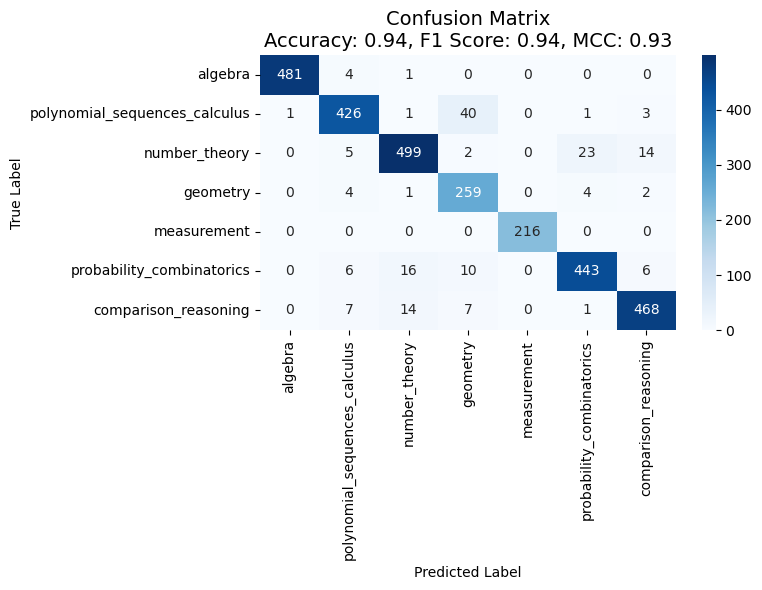

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)

# Add accuracy, F1 score, and MCC in the title
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, MCC: {mcc:.2f}', fontsize=14)

# Label axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix.png")
plt.show()


# Boosting

In [100]:
#epsilon is the valid differenct gap between highest and second highest value
def get_fall_prediction(X, Y, tokenizer, model, epsilon = 1):
    BATCH_SIZE = 32 #batch size to reduce memory consumsion
    output_list = [] #the model prediction
    different_list = [] #different between the highest and second highest value
    for i in range(0,len(X),BATCH_SIZE):
        predict_input = tokenizer(X[i:i+BATCH_SIZE],truncation=True,padding=True,return_tensors="tf")
        output = model(predict_input)[0]
        output_list.extend(np.argmax(output,axis=1))
        
        #calculate the different
        max_vals = np.max(output, axis=1)
        masked_output = np.where(output == max_vals[:, None], -np.inf, output)
        second_max_vals = np.max(masked_output, axis=1)
        different_list.extend(max_vals - second_max_vals)
    
    output_list = np.array(output_list)
    different_list = np.array(different_list)

    #mask filter
    incorrect_mask = (output_list != Y) #mask where the prediction is incorrect
    uncertainty_mask = np.where(different_list < epsilon,True,False) #mask where not confident in the prediction.
    filter_mask = (incorrect_mask | uncertainty_mask)
    
    #get incorrect prediction
    X_wrong = np.array(X)[filter_mask].tolist()
    Y_wrong = np.array(Y)[filter_mask].tolist()

    return X_wrong, Y_wrong

In [101]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")

/home/qdang1/.conda/envs/tf2/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [102]:
X_train_1, Y_train_1 = get_fall_prediction(X_train, y_train, tokenizer, model_loaded, epsilon = 3)

print(len(X_train_1))
print(len(Y_train_1))

1437
1437


In [103]:
train_encodings = tokenizer(X_train_1, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [104]:
train_dataset = tf.data.Dataset.from_tensor_slices((
dict(train_encodings),
list(Y_train_1)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
dict(test_encodings),
list(y_test)
))

In [105]:
PATIENCE = 8
EPOCH = 10
BATCH_SIZE = 32

In [106]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.0001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True)

model.fit(train_dataset.shuffle(1000).batch(BATCH_SIZE),epochs=EPOCH,batch_size=BATCH_SIZE,callbacks=[reduce_LR_On_Plateau,early_stopping])

Epoch 1/10
45/45 [==============================] - 28s 631ms/step - loss: 0.6180 - accuracy: 0.7752 - lr: 1.2500e-05
Epoch 2/10
45/45 [==============================] - 28s 632ms/step - loss: 0.4132 - accuracy: 0.8399 - lr: 1.2500e-05
Epoch 3/10
45/45 [==============================] - 29s 634ms/step - loss: 0.2961 - accuracy: 0.8866 - lr: 1.2500e-05
Epoch 4/10
45/45 [==============================] - 29s 634ms/step - loss: 0.2330 - accuracy: 0.9109 - lr: 1.2500e-05
Epoch 5/10
45/45 [==============================] - 29s 634ms/step - loss: 0.1833 - accuracy: 0.9346 - lr: 1.2500e-05
Epoch 6/10
45/45 [==============================] - 29s 634ms/step - loss: 0.1362 - accuracy: 0.9506 - lr: 1.2500e-05
Epoch 7/10
45/45 [==============================] - 29s 634ms/step - loss: 0.1232 - accuracy: 0.9569 - lr: 1.2500e-05
Epoch 8/10
45/45 [==============================] - 28s 630ms/step - loss: 0.0935 - accuracy: 0.9729 - lr: 1.2500e-05
Epoch 9/10
45/45 [==============================] - 28s 

In [107]:
model.save_pretrained(OUTPUT_DIR + 'model1')

In [108]:
model1 = TFDistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR + 'model1')

Some layers from the model checkpoint at /nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run10/model1 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run10/model1 and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

In [109]:
output_list = []
for i in range(0,len(X_test),32):
    predict_input = tokenizer(X_test[i:i+32],truncation=True,padding=True,return_tensors="tf")
    output = model1(predict_input)[0]
    output_list.extend(output)

output_list = np.array(output_list)
output_list.shape

(2965, 7)

In [110]:
y_pred = np.argmax(output_list,axis=1)

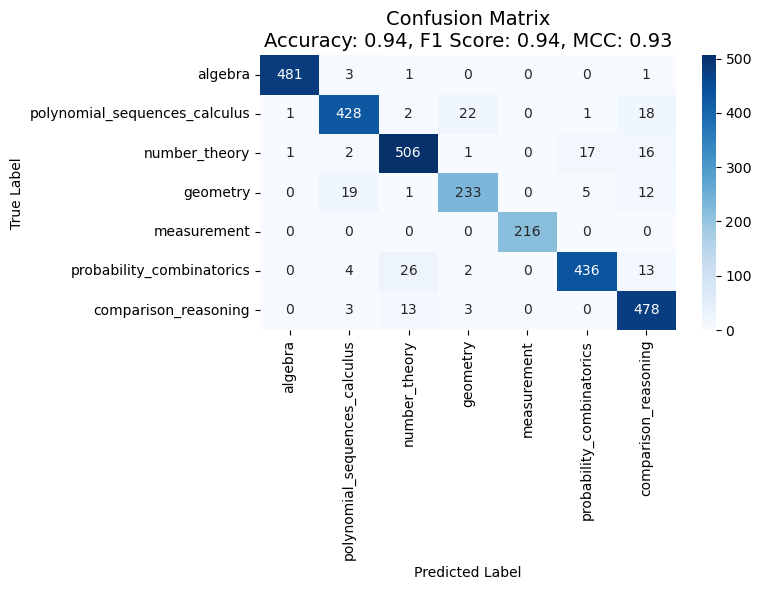

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)

# Add accuracy, F1 score, and MCC in the title
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, MCC: {mcc:.2f}', fontsize=14)

# Label axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_model_1.png")
plt.show()


### model all, add

In [112]:
model0 = TFDistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR + 'model0')
model1 = TFDistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR + 'model1')

Some layers from the model checkpoint at /nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run10/model0 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run10/model0 and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

In [113]:
output_list = []
for i in range(0,len(X_test),32):
    predict_input = tokenizer(X_test[i:i+32],truncation=True,padding=True,return_tensors="tf")
    output0 = model0(predict_input)[0]
    output1 = model1(predict_input)[0]
    output_list.extend(output0 + output1)

output_list = np.array(output_list)
output_list.shape

(2965, 7)

In [114]:
y_pred = np.argmax(output_list,axis=1)

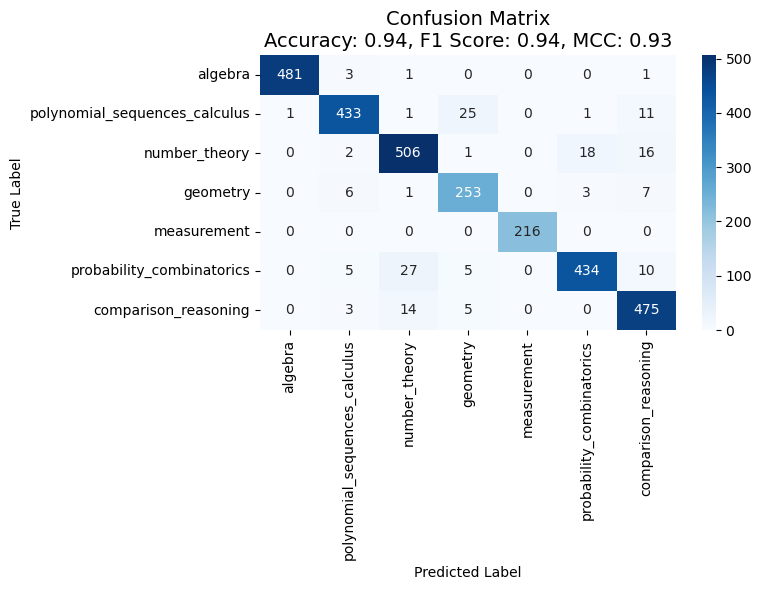

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)

# Add accuracy, F1 score, and MCC in the title
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, MCC: {mcc:.2f}', fontsize=14)

# Label axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix_model_all.png")
plt.show()
